## <p align='center'><u><b> Primera implementación: Ecuación de Poisson </b></u></p>

#### <b> Ecuación de Poisson para deformación de láminas delgadas <b>

En teoría de elasticidad la ecuación diferencial

$$
D \, \nabla ^2 w(x,y) = Q(x,y)
$$

con

D : Rigidez de flexión

$$
D = \frac{E h^3}{12 (1-\nu^2)}
$$

- E: Módulo de Young
- h: Grosor de la tela
- $\nu$: Coeficiente de Poisson
(Todas estas con propiedades intrínsecas de la tela)

w : Deformación vertical \
Q : Carga externa de la tela



describe la deformación de una lámina delgada bajo una carga distribuida $Q(x,y)$, donde $D$ es la rigidez a la flexión de la lámina y $w(x,y)$ 
representa el desplazamiento transversal.

$$
D \left( \frac{\partial^2 w}{\partial x^2} + \frac{\partial^2 w}{\partial y^2} \right) = Q(x,y)
$$

Dada la naturaleza polar del problema (hablamos de la forma del soporte), es mejor usar el laplaciano en coordenadas polares
$$
D \left( \frac{\partial^2 w}{\partial r^2} + \frac{1}{r} \frac{\partial w}{\partial r} + \frac{1}{r^2}\frac{\partial^2 w}{\partial \theta^2} \right) = Q(r,\theta)
$$

Para tratar esta ecuación usaremos diferencias finitas de la siguiente forma:

$$
D \left( \frac{w_{i+1,j} - 2w_{i,j} + w_{i-1,j}}{\Delta r^2} + \frac{1}{r_i} \frac{w_{i+1,j} - w_{i-1,j}}{\Delta r} + \frac{1}{r_i^2} \frac{w_{i,j+1} - 2w_{i,j} + w_{i,j-1}}{\Delta \theta^2}\right) = Q(r,\theta)
$$

donde $i$ y $j$ son representativos a $r$ y $\theta$ respectivamente.

Ahora bien, reorganizamos la ecuación

$$
\left(- \frac{2D}{\Delta r^2} - \frac{1}{r_i^2}\frac{2D}{\Delta \theta^2}\right) w_{i,j} + \left(\frac{2D}{\Delta r^2} + \frac{1}{r_i}\frac{1}{2 \Delta r}\right) w_{i+1,j} + \left( \frac{D}{\Delta r^2} - \frac{1}{r_i} \frac{1}{2 \Delta r^2} \right) w_{i-1,j} + \left( \frac{1}{r_i^2} \frac{D}{\Delta \theta^2} \right) w_{i,j+1} + \left( \frac{1}{r_i^2} \frac{D}{\Delta \theta^2} \right) w_{i,j-1} = Q(r, \theta)
$$

Lo que corresponde a un sistema de ecuaciones lineales no homogeneas, por lo que el problema se reduce a resolver un SEL.

In [2]:
#Importación de librerías
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  

In [13]:
# Parámetros del problema
R = 0.65        # Radio de la tela
N_r = 200       # Puntos en la dirección radial
N_theta = 200   # Puntos en la dirección angular
D = 50.0        # Rigidez a la flexión

dr = R / (N_r - 1)                                        # Diferencial de radio
dtheta = 2 * np.pi / N_theta                              # Diferencial de ángulo
r = np.linspace(0, R, N_r)                                # Vector radio
theta = np.linspace(0, 2*np.pi, N_theta)                  # Vector ángulo
R_grid, Theta_grid = np.meshgrid(r, theta, indexing="ij") # Mallas descriptivas

In [14]:
# Función de carga externa 
def f(r, theta):
    return np.exp(-10 * r**2) # Esto es una carga puntual, habrá que ajustarla para nuestro problema

F = f(R_grid, Theta_grid)

In [15]:
# Construcción de la matriz del sistema
'''
La idea es contruir A y b representativas de la ecuación de Poisson tal que Ax = b, es decir, es resolver un S.E.L, de modo que la solución
de este sistema es la deformación en z de la tela
'''

N = N_r * N_theta         # Tamaño de la matriz representativa
A = sp.lil_matrix((N, N)) # Aparentemente la estructura List of List es mejor en estos casos
b = F.flatten()

#Construcción de la Matriz A
'''
Aquí ya tenemos la matriz A vacía, se recorrerá para llenarla según la discretización.
El primer paso es calcular los índices necesarios para implementar la discretización. Hay un problema en los bordes (como siempre) por lo que se tendrán en cuenta
condiciones periódicas.

'''
for i in range(1, N_r - 1):
    for j in range(N_theta):
        idx = i * N_theta + j
        r_i = r[i]
        
        # ÍCálculos de índices vecinos, para facilitar la legibilidad del código
        idx_r_plus = (i + 1) * N_theta + j # (r+1,theta)
        idx_r_minus = (i - 1) * N_theta + j # (r-1,theta)
        idx_theta_plus = i * N_theta + (j + 1) % N_theta  # Condiciones periódicas
        idx_theta_minus = i * N_theta + (j - 1) % N_theta  
        
        # Coeficientes de la ecuación discretizada
        A[idx, idx] = -2 * D / dr**2 - 2 * D / (r_i**2 * dtheta**2)
        A[idx, idx_r_plus] = D / dr**2 + D / (2 * r_i * dr)
        A[idx, idx_r_minus] = D / dr**2 - D / (2 * r_i * dr)
        A[idx, idx_theta_plus] = D / (r_i**2 * dtheta**2)
        A[idx, idx_theta_minus] = D / (r_i**2 * dtheta**2)

# Condición de frontera: w(R, θ) = 0
for j in range(N_theta):
    idx = (N_r - 1) * N_theta + j # Indexación atípica de matrices
    A[idx, idx] = 1
    b[idx] = 0

# Condición de continuidad en r=0 (centro de la tela)
for j in range(N_theta):
    idx = 0 * N_theta + j  # Punto en r=0
    idx_r_plus = 1 * N_theta + j  # Punto en r=dr
    
    # Condición de continuidad: w(0, θ) = w(1, θ)
    A[idx, idx] = 1
    A[idx, idx_r_plus] = -1
    b[idx] = 0

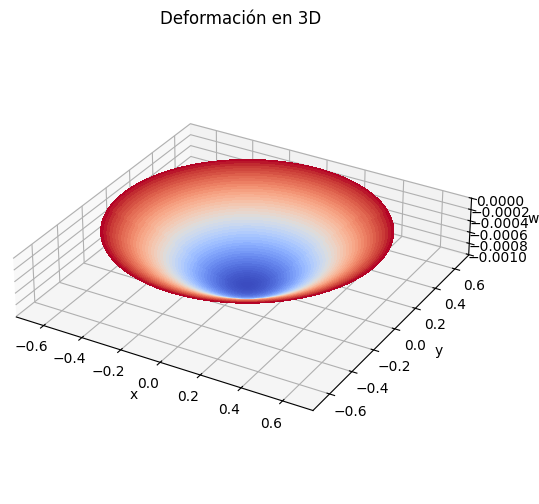

In [16]:
# Resolviendo el sistema
A = A.tocsr()  # LIL a CSR (Compressed sparse row) (pa mejorar el producto matricial)
w = spla.spsolve(A, b) # Resolver el SEL, w es la deformación vertical de la tela

# Ahora w es un vector de tamaño (N_r*N_theta,), es necesario reformatearla para graficar (N_r*N_theta,) -> (N_r,N_theta) 
W = w.reshape(N_r, N_theta)

# Convertir a coordenadas cartesianas para la gráfica
X = R_grid * np.cos(Theta_grid)  # x = r * cos(theta)
Y = R_grid * np.sin(Theta_grid)  # y = r * sin(theta)

# Gráfica en 3D
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
c = ax.plot_surface(X, Y, W, cmap="coolwarm", linewidth=0, antialiased=False)
#fig.colorbar(c, ax=ax, shrink=0.7, aspect=20, label="Desplazamiento w") #Solo hace estorbo
ax.set_title("Deformación en 3D")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("w")

# Ajustar escalas
ax.set_box_aspect([1, 1, 0.2])  # Ajusta la proporción de los ejes
ax.set_zlim(np.min(W), np.max(W))  # Ajusta los límites del eje z

plt.show()

Al final, el problema se reduce a realizar el modelado del perfil de la curvatura, entonces visualizaremos el perfil creado por este modelo.

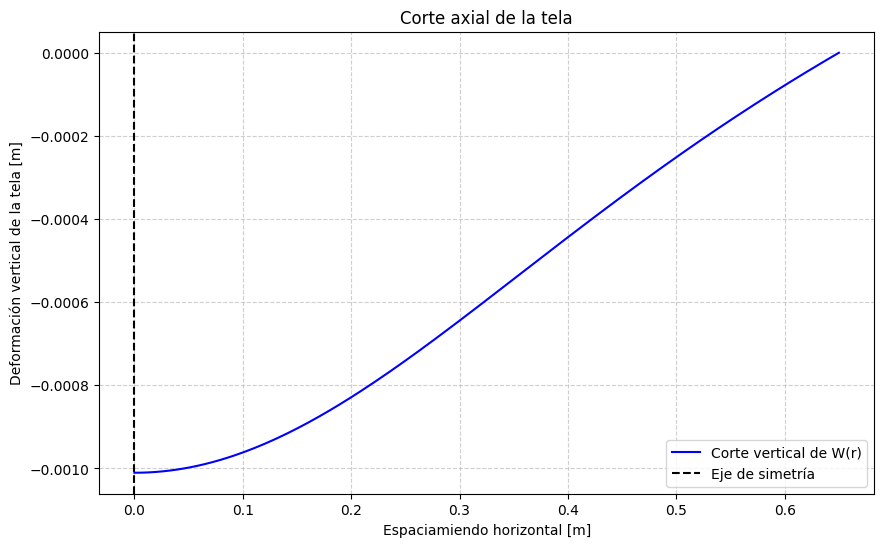

In [25]:
# Superficie de nivel
theta_corte = 0  
indice_theta = np.argmin(np.abs(Theta_grid[0, :] - theta_corte))

r_corte = R_grid[:, indice_theta]  
W_corte = W[:, indice_theta]      

plt.figure(figsize=(10, 6))
plt.plot(r_corte, W_corte, label="Corte vertical de W(r)", color='b')
plt.xlabel("Espaciamiendo horizontal [m]")
plt.ylabel("Deformación vertical de la tela [m]")
plt.title("Corte axial de la tela")
plt.axvline(x=0, color="black", linestyle="--", label="Eje de simetría")

# Hacer que los ejes tengan escalas iguales
#plt.axis("equal") 
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

# Mostrar la gráfica
plt.show()